<a href="https://colab.research.google.com/github/Sindhuhar/deep_learning/blob/main/cpu_gpu_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Network Training with Distributed Training and Google TPUs


### Import Packages

In [2]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
# import the necessary packages
from tensorflow import reduce_mean
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.losses import Reduction
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.image import convert_image_dtype
from tensorflow.keras.preprocessing.image import array_to_img
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### Define the data-pipeline

In [4]:
def pre_process(element):
	# convert image data type from uint8 to float32
    image = convert_image_dtype(element["image"], dtype=tf.float32)

	# return images as a tuple
    return (image, image)

def get_data(dataName, split, batchSize, shuffleSize=None):
	# adding an assert to check for a valid split argument
	assert split in ["train", "test"], "Please provide a valid split."

	# check if this is a training split
	if split == "train":
		# get the training split
		print("[INFO] downloading the train split...")
		dataset = tfds.load(name=dataName, split=split,
			try_gcs=True)
		dataset = (dataset
			.map(pre_process)
			.shuffle(shuffleSize)
			.repeat()
			.batch(batchSize))

	else:
		# otherwise, it's a testing split
		print("[INFO] downloading the test split...")
		dataset = tfds.load(name=dataName, split=split,
			try_gcs=True)
		dataset = (dataset
			.map(pre_process)
			.batch(batchSize))

	# return the dataset
	return dataset

### Define the loss


In [5]:
class MSELoss():
    def __init__(self, scale):
        # accept the scalar by which the loss needs to be scaled
        self.scale = scale

    def __call__(self, real, pred):
        # initialize MeanSquaredError loss with no reduction
        MSE = MeanSquaredError(reduction=Reduction.NONE)

        # compute the loss
        loss = MSE(real, pred)

        # scale the loss
        loss = reduce_mean(loss) * (1. / self.scale)

        # return loss
        return loss

### Define the model

In [6]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        # build the encoder
        self.encoder = Sequential([
            InputLayer((28, 28, 1)),
            Conv2D(16, (3, 3), activation='relu', padding='same',
                strides=2),
            Conv2D(8, (3, 3), activation='relu', padding='same',
                strides=2)])

        # build the decoder
        self.decoder = Sequential([
            Conv2DTranspose(8, kernel_size=3, strides=2,
                activation='relu', padding='same'),
            Conv2DTranspose(16, kernel_size=3, strides=2,
                activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid',
                padding='same')])

    def call(self, x):
        # pass the input through the encoder and output of the encoder
        # through the decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # return the output from the decoder
        return decoded

### Create the config

In [7]:
class config:
    # define the dataset name and TFDS flags
    TRAIN_FLAG = "train"
    VALIDATION_FLAG = "test"
    DATA_NAME = "mnist"

    # define the various batch sizes
    BATCH_SIZE = 128
    TPU_BATCH_SIZE = 8 * 128

    # define the shuffle size and number of epochs
    SHUFFLE_SIZE = 10000
    EPOCHS = 5

    # calculate steps per epoch for training set
    STEPS_PER_EPOCH = 60000 // BATCH_SIZE
    TPU_STEPS_PER_EPOCH = 60000 // TPU_BATCH_SIZE

    # calculate steps per epoch for validation set
    VALIDATION_STEPS = 10000 // BATCH_SIZE
    TPU_VALIDATION_STEPS = 10000 // TPU_BATCH_SIZE

    # define the optimizer
    OPTIMIZER = "adam"

    # define the base output path and build image output paths
    BASE_IMG_PATH = "outputs"
    CPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "cpu.png")
    GPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "gpu.png")
    TPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "tpu.png")

### Train with <font color=red>**CPUs**</font>

Steps to follow before executing this code snippet:
- Go to `Runtime`
- Select `Change runtime type`
- Under `Hardware accelerator` select `None`

This ensures that you are using **CPU** to run the code below.

[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training the autoencoder...
Epoch 1/5
468/468 [==============================] - 100s 193ms/step - loss: 0.0363 - val_loss: 0.0042
Epoch 2/5
468/468 [==============================] - 77s 164ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 3/5
468/468 [==============================] - 77s 165ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/5
468/468 [==============================] - 80s 171ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/5
468/468 [==============================] - 77s 166ms/step - loss: 0.0016 - val_loss: 0.0014
[INFO] running inference...
[INFO] evaluating the model...
4/4 [==============================] - 0s 12ms/step
[INFO] displaying the predicted images...
[INFO] saving the predicted images...


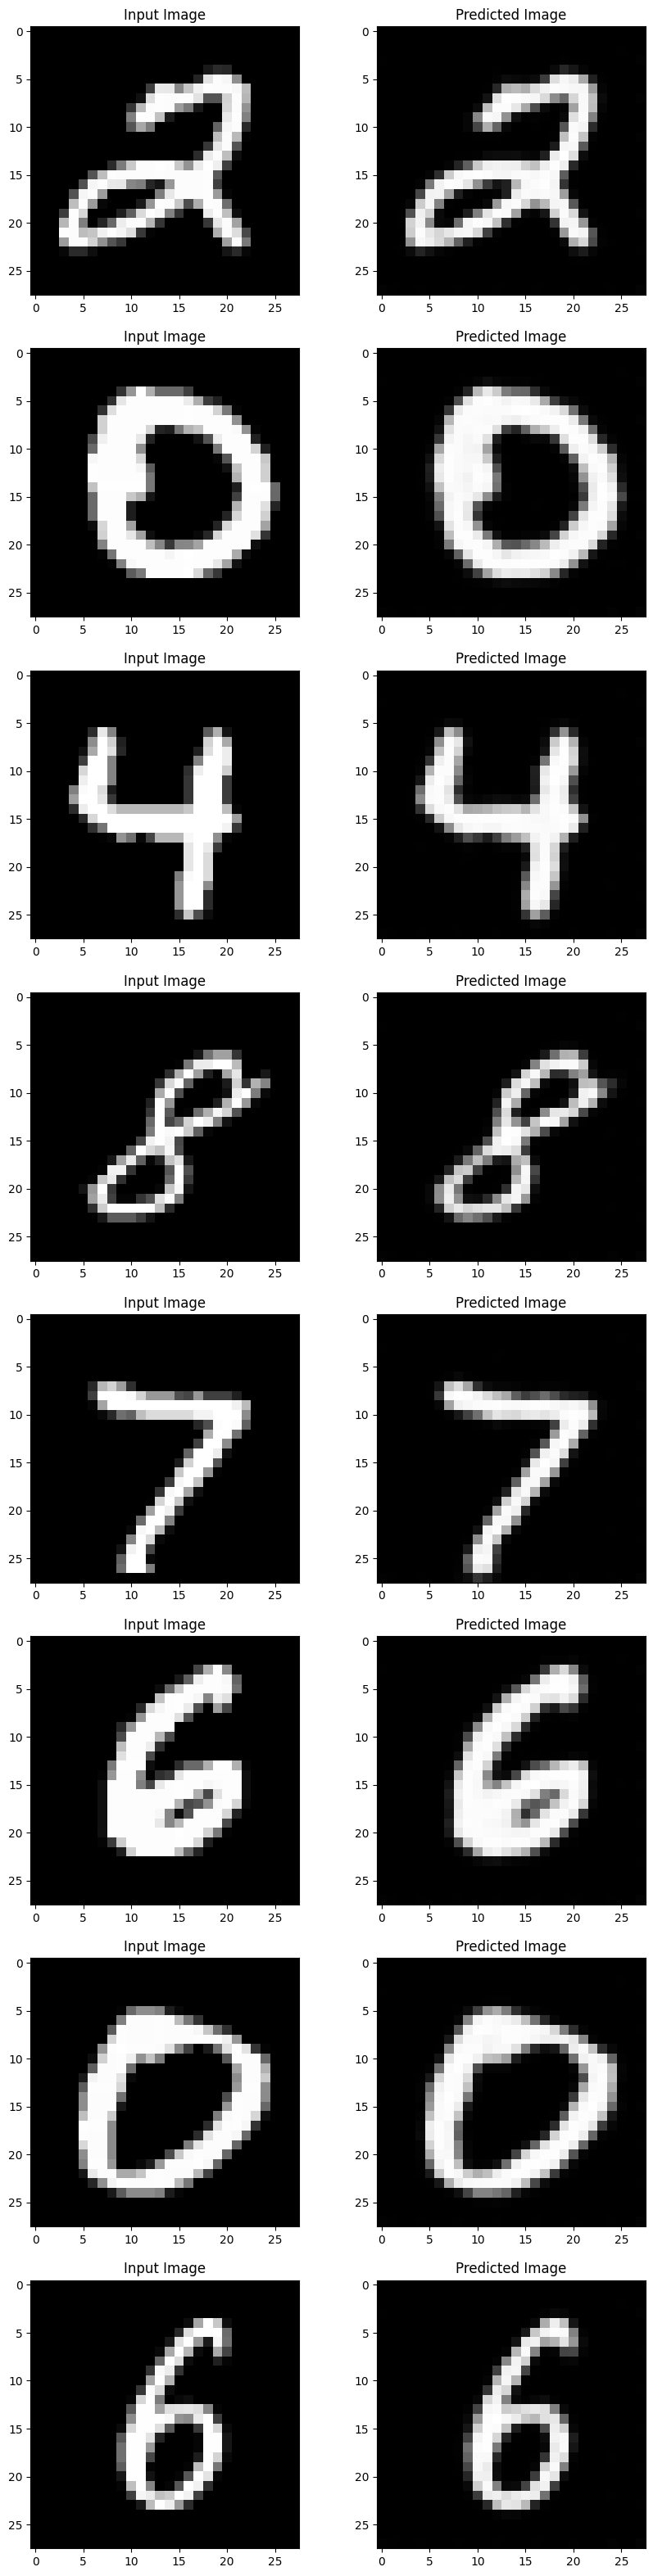

In [8]:
# get the training dataset
print("[INFO] loading the training and validation datasets...")
trainDs = get_data(dataName=config.DATA_NAME,
	split=config.TRAIN_FLAG, shuffleSize=config.SHUFFLE_SIZE,
	batchSize=config.BATCH_SIZE)

# get the validation dataset
valDs = get_data(dataName=config.DATA_NAME,
	split=config.VALIDATION_FLAG, batchSize=config.BATCH_SIZE)

# initialize the autoencoder model and compile it
print("[INFO] initializing the model...")
model = AutoEncoder()
mseLoss = MSELoss(scale=1)
model.compile(loss=mseLoss, optimizer=config.OPTIMIZER)

# train the model
print("[INFO] training the autoencoder...")
model.fit(trainDs, epochs=config.EPOCHS,
	steps_per_epoch=config.STEPS_PER_EPOCH,
	validation_data=valDs,
	validation_steps=config.VALIDATION_STEPS)

# run inference
print("[INFO] running inference...")
(testIm, _) = next(iter(valDs))
print("[INFO] evaluating the model...")
predIm = model.predict(testIm)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over the subplots and fill with test and predicted images
print("[INFO] displaying the predicted images...")
for ax, real, pred in zip(axes, testIm[:8], predIm[:8]):
	# plot the input image
	ax[0].imshow(array_to_img(real), cmap="gray")
	ax[0].set_title("Input Image")

	# plot the predicted image
	ax[1].imshow(array_to_img(pred), cmap="gray")
	ax[1].set_title("Predicted Image")

# check if the output image directory exists, if does not, then create
# it
if not os.path.exists(config.BASE_IMG_PATH):
	os.makedirs(config.BASE_IMG_PATH)

# save the figure
print("[INFO] saving the predicted images...")
fig.savefig(config.CPU_IMG_PATH)

### Train with <font color=orange>**GPUs**</font>

Steps to follow before executing this code snippet:
- Go to `Runtime`
- Select `Change runtime type`
- Under `Hardware accelerator` select `GPU`

This ensures that you are using **GPU** to run the code below.

In [9]:
from tensorflow.config import list_physical_devices

[INFO] number of available GPUs: 0
[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training the autoencoder...
Epoch 1/5
468/468 [==============================] - 84s 172ms/step - loss: 0.0364 - val_loss: 0.0037
Epoch 2/5
468/468 [==============================] - 81s 173ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 3/5
468/468 [==============================] - 77s 165ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/5
468/468 [==============================] - 81s 172ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/5
468/468 [==============================] - 77s 165ms/step - loss: 0.0016 - val_loss: 0.0015
[INFO] running inference...
[INFO] evaluating the model...
4/4 [==============================] - 0s 13ms/step
[INFO] displaying the predicted images...
[INFO] saving the predicted images...


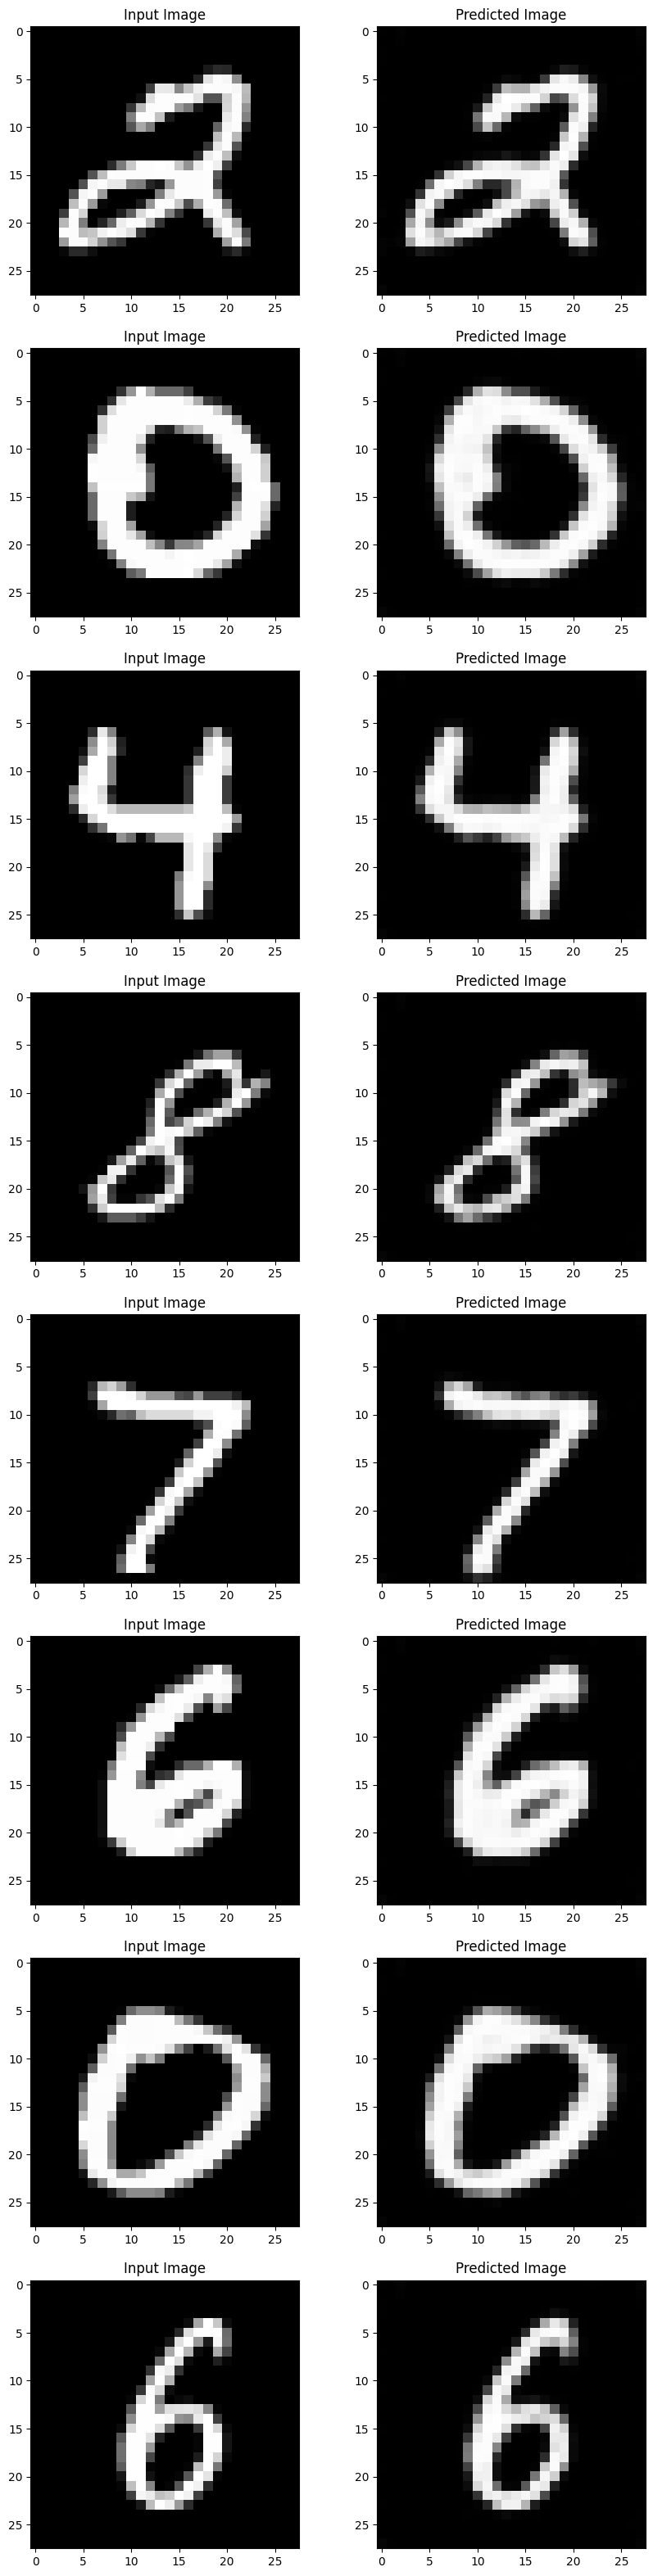

In [10]:
# check for GPU availability
numGPU = len(list_physical_devices("GPU"))
print(f"[INFO] number of available GPUs: {numGPU}")

# get the training dataset
print("[INFO] loading the training and validation datasets...")
trainDs = get_data(dataName=config.DATA_NAME,
	split=config.TRAIN_FLAG, shuffleSize=config.SHUFFLE_SIZE,
	batchSize=config.BATCH_SIZE)

# get the validation dataset
valDs = get_data(dataName=config.DATA_NAME,
	split=config.VALIDATION_FLAG, batchSize=config.BATCH_SIZE)

# initialize the autoencoder model and compile it
print("[INFO] initializing the model...")
model = AutoEncoder()
mseLoss = MSELoss(scale=1)
model.compile(loss=mseLoss, optimizer=config.OPTIMIZER)

# train the model
print("[INFO] training the autoencoder...")
model.fit(trainDs, epochs=config.EPOCHS,
	steps_per_epoch=config.STEPS_PER_EPOCH,
	validation_data=valDs,
	validation_steps=config.VALIDATION_STEPS)

# run inference
print("[INFO] running inference...")
(testIm, _) = next(iter(valDs))
print("[INFO] evaluating the model...")
predIm = model.predict(testIm)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over the subplots and fill with test and predicted images
print("[INFO] displaying the predicted images...")
for ax, real, pred in zip(axes, testIm[:8], predIm[:8]):
	# plot the input image
	ax[0].imshow(array_to_img(real), cmap="gray")
	ax[0].set_title("Input Image")

	# plot the predicted image
	ax[1].imshow(array_to_img(pred), cmap="gray")
	ax[1].set_title("Predicted Image")

# check if the output image directory exists, if does not, then create
# it
if not os.path.exists(config.BASE_IMG_PATH):
	os.makedirs(config.BASE_IMG_PATH)

# save the figure
print("[INFO] saving the predicted images...")
fig.savefig(config.GPU_IMG_PATH)

### Train with <font color=lightgreen>**TPUs**</font>

Steps to follow before executing this code snippet:
- Go to `Runtime`
- Select `Change runtime type`
- Under `Hardware accelerator` select `TPU`

This ensures that you are using **TPU** to run the code below.

In [11]:
from tensorflow import distribute
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.config import experimental_connect_to_cluster

In [12]:
# initialize the TPU and TPU strategy
tpu = distribute.cluster_resolver.TPUClusterResolver()
experimental_connect_to_cluster(tpu)
initialize_tpu_system(tpu)
strategy = distribute.TPUStrategy(tpu)

In [13]:
# get the number of accelerators
numAcc = strategy.num_replicas_in_sync
print(f"[INFO] Number of accelerators: {numAcc}")

[INFO] Number of accelerators: 8


[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training the autoencoder...
Epoch 1/5
58/58 [==============================] - 10s 60ms/step - loss: 0.1755 - val_loss: 0.0951
Epoch 2/5
58/58 [==============================] - 2s 30ms/step - loss: 0.0576 - val_loss: 0.0245
Epoch 3/5
58/58 [==============================] - 2s 30ms/step - loss: 0.0157 - val_loss: 0.0108
Epoch 4/5
58/58 [==============================] - 2s 33ms/step - loss: 0.0091 - val_loss: 0.0073
Epoch 5/5
58/58 [==============================] - 2s 33ms/step - loss: 0.0064 - val_loss: 0.0053
[INFO] evaluating the model...
32/32 [==============================] - 2s 25ms/step
[INFO] displaying the predicted images...
[INFO] saving the predicted images...


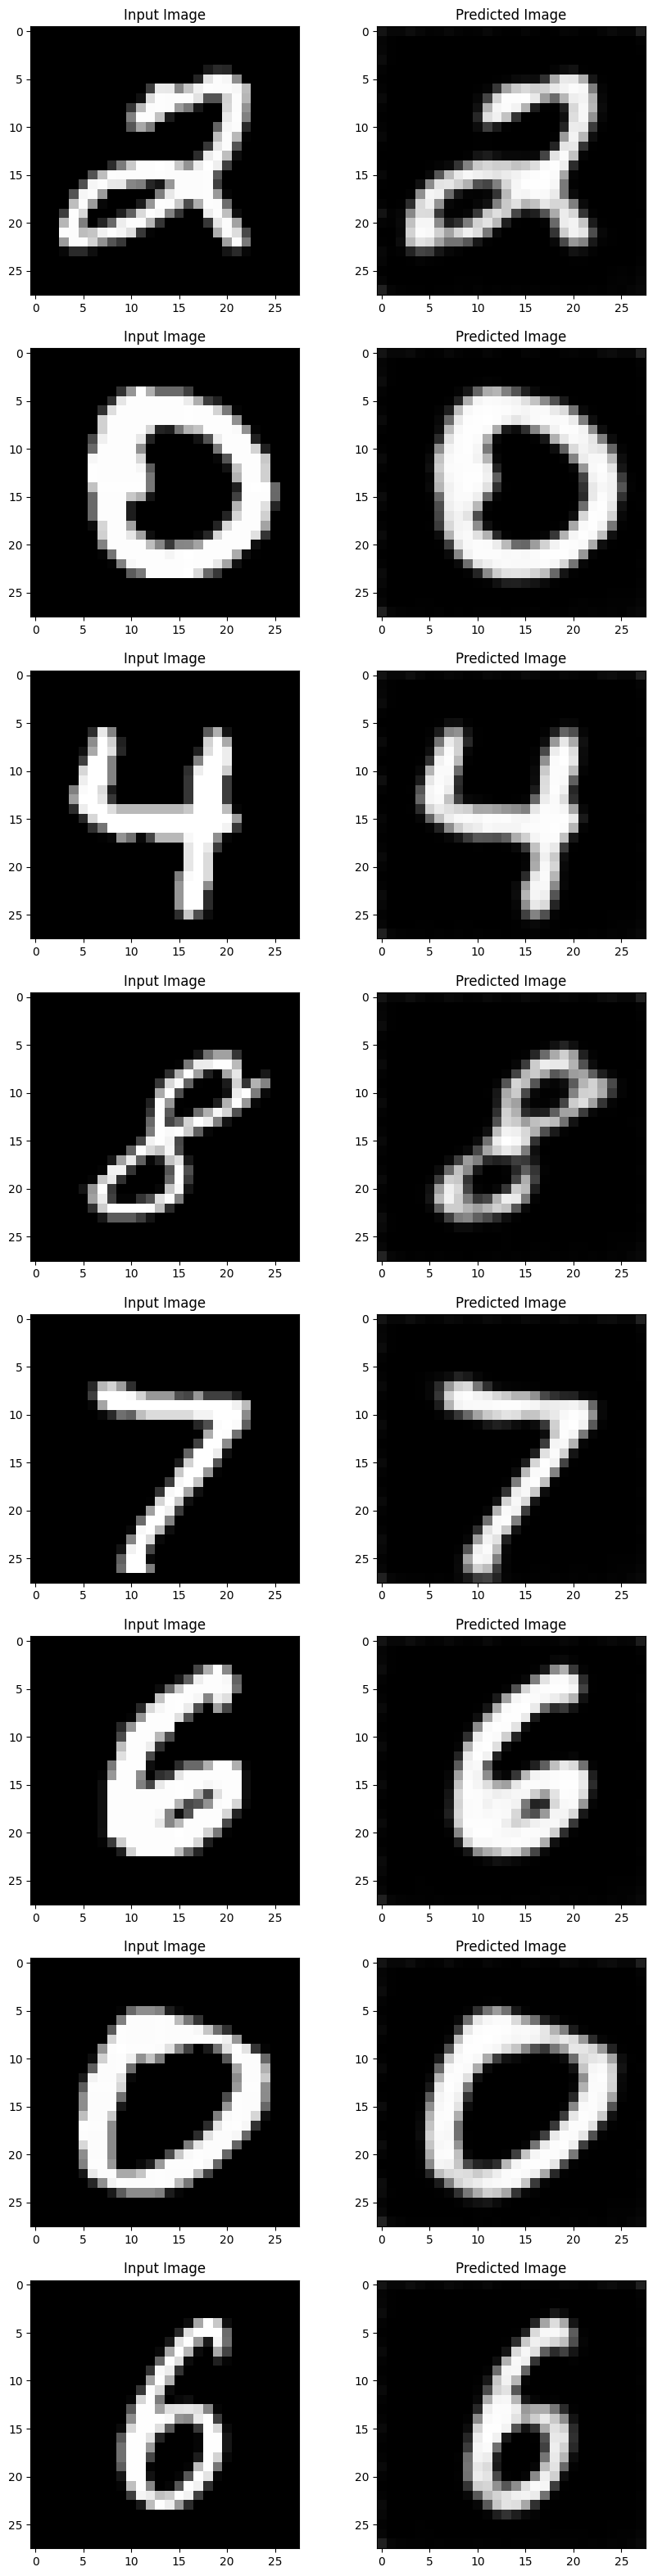

In [14]:
# get the training dataset
print("[INFO] loading the training and validation datasets...")
trainDs = get_data(dataName=config.DATA_NAME,
	split=config.TRAIN_FLAG, shuffleSize=config.SHUFFLE_SIZE,
	batchSize=config.TPU_BATCH_SIZE)

# get the validation dataset
valDs = get_data(dataName=config.DATA_NAME,
	split=config.VALIDATION_FLAG, batchSize=config.TPU_BATCH_SIZE)

# train the model in the scope
with strategy.scope():
	# initialize the autoencoder model and compile it
	print("[INFO] initializing the model...")
	model = AutoEncoder()
	mseLoss = MSELoss(scale=1)
	model.compile(loss=mseLoss, optimizer=config.OPTIMIZER)

	# train the model
	print("[INFO] training the autoencoder...")
	model.fit(trainDs, epochs=config.EPOCHS,
		steps_per_epoch=config.TPU_STEPS_PER_EPOCH,
		validation_data=valDs,
		validation_steps=config.TPU_VALIDATION_STEPS)

# grab a batch of data from the test set and run inference
print("[INFO] evaluating the model...")
(testIm, _) = next(iter(valDs))
predIm = model.predict(testIm)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over the subplots and fill with test and predicted images
print("[INFO] displaying the predicted images...")
for ax, real, pred in zip(axes, testIm[:8], predIm[:8]):
	# plot the input image
	ax[0].imshow(array_to_img(real), cmap="gray")
	ax[0].set_title("Input Image")

	# plot the predicted image
	ax[1].imshow(array_to_img(pred), cmap="gray")
	ax[1].set_title("Predicted Image")

# check if the output image directory exists, if does not, then create
# it
if not os.path.exists(config.BASE_IMG_PATH):
	os.makedirs(config.BASE_IMG_PATH)

# save the figure
print("[INFO] saving the predicted images...")
fig.savefig(config.TPU_IMG_PATH)